In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-white')
orange, purple, elm ='#FFCC00', '#666599', '#217C7E'
blue, red, grey, green ='#336699', '#9A3334', '#AAAAAA', '#335333'
%matplotlib inline
mydpi=600
s=18

__author__ = 'HK Dambanemuya'
__version__ = 'Python2'

In [2]:
print ("Reading News...")
news = pd.read_csv("../../Data/Fusion/news.csv")
news = news[news['length']>100]
news['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(news['date'])]

print ("Reading Blogs...")
blogs = pd.read_csv("../../Data/Fusion/blogs.csv")
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(blogs['date'])]

print ("Reading Discussions...")
discussions = pd.read_csv("../../Data/Fusion/discussions.csv")
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(discussions['date'])]

Reading News...



Reading Blogs...



Reading Discussions...


In [3]:
# Select countries common in all 3 data sets
country_map = Counter(set(news['country']))+Counter(set(blogs['country']))+Counter(set(discussions['country']))
common_locations = []
for k,v in tqdm_notebook(country_map.items()):
    if (v == 3) and (k==k):
        common_locations.append(k)
print("Common Countries:", len(common_locations))


('Common Countries:', 79)


In [4]:
# Filter data by common countries
news = news[news['country'].isin(common_locations)]
blogs = blogs[blogs['country'].isin(common_locations)]
discussions = discussions[discussions['country'].isin(common_locations)]
print ("News:", len(news))
print ("Blogs:", len(blogs))
print ("Discussions:", len(discussions))

('News:', 2277563)
('Blogs:', 946755)
('Discussions:', 409091)


In [5]:
dates = sorted(list(set(news['date']).union(set(blogs['date'])).union(set(discussions['date']))))[1:-1]

In [6]:
def cov(arr):
    return np.true_divide(np.std(arr), np.mean(arr)) 

In [7]:
theme_labels = ['medical supplies', 'ppe', 'recommendations', 'restrictions', 'seasonal flu']
theme_labels_ = ['Medical \n Supplies', 'PPE', 'Recommendations', 'Restrictions', 'Seasonal \n Flu']

In [8]:
def get_theme_statistics(themes_list):
    
    sources = ['News', 'Blogs', 'Discussions']*len(theme_labels)
    themes = []
    volume = []
    proportion = []
    variability = []
    popularity = []
    engagement = []
    prominence = []
    sentiment = []
    
    for theme in tqdm_notebook(themes_list):
        
        themes.extend([theme]*3)
        
        # theme Volume: Total number of articles that belong to theme
        volume.extend([len(news[news['theme'].str.contains(theme)]),
                       len(blogs[blogs['theme'].str.contains(theme)]),
                       len(discussions[discussions['theme'].str.contains(theme)])])
        
        # theme Share: Number of articles that belong to theme / total number of articles   
        proportion.extend([np.true_divide(len(news[news['theme'].str.contains(theme)]),len(news))*100,
                           np.true_divide(len(blogs[blogs['theme'].str.contains(theme)]),len(blogs))*100,
                           np.true_divide(len(discussions[discussions['theme'].str.contains(theme)]),len(discussions))*100])
                                         
        # theme Variability: Coefficient of variation in theme's daily volume
        variability.extend([cov(news[news['theme'].str.contains(theme)][['date', 'text']].groupby('date').agg('count')['text'].values),
                           cov(blogs[blogs['theme'].str.contains(theme)][['date', 'text']].groupby('date').agg('count')['text'].values),
                           cov(discussions[discussions['theme'].str.contains(theme)][['date', 'text']].groupby('date').agg('count')['text'].values)])
        
        # theme Popularity: Total number of participants on the theme
        popularity.extend([news[news['theme'].str.contains(theme)]['participants'].sum(),
                       blogs[blogs['theme'].str.contains(theme)]['participants'].sum(),
                       discussions[discussions['theme'].str.contains(theme)]['participants'].sum()])
        
        # theme Engagement: Total number of replies on the theme
        engagement.extend([news[news['theme'].str.contains(theme)]['replies'].sum(),
                       blogs[blogs['theme'].str.contains(theme)]['replies'].sum(),
                       discussions[discussions['theme'].str.contains(theme)]['replies'].sum()])
        
        # theme Prominence: Total number of distinct days theme was reported or discussed in online media
        prominence.extend([news[news['theme'].str.contains(theme)]['date'].nunique(),
                       blogs[blogs['theme'].str.contains(theme)]['date'].nunique(),
                       discussions[discussions['theme'].str.contains(theme)]['date'].nunique()])
    
        # theme Sentiment: VADER
        sentiment.extend([news[news['theme'].str.contains(theme)]['sentiment'].mean(),
                       blogs[blogs['theme'].str.contains(theme)]['sentiment'].mean(),
                       discussions[discussions['theme'].str.contains(theme)]['sentiment'].mean()])
    
    df = pd.DataFrame()
    df['Theme'] = themes
    df['Source'] = sources
    df['Volume'] = volume
    df['Proportion'] = proportion
    df['Variability'] = variability
    df['Popularity'] = popularity
    df['Engagement'] = engagement
    df['Prominence'] = prominence
    df['Sentiment'] = sentiment
    
    return df


In [9]:
def plot_theme_variable(variable, yscale='log'):
    
    ind = np.arange(len(theme_labels))    
    width = 0.25
    if variable == 'Sentiment':
        fig = plt.figure(figsize=(5,10), dpi=mydpi)
        plt.style.use('seaborn-whitegrid')
        plt.barh(ind, theme_statistics[theme_statistics['Source'].str.contains('News')][variable], width, color=elm, label='News Articles')
        plt.barh(ind+width, theme_statistics[theme_statistics['Source']=='Blogs'][variable], width, color=orange, label='Blog Posts')
        plt.barh(ind+width*2, theme_statistics[theme_statistics['Source']=='Discussions'][variable], width, color=purple, label='Discussions')
        plt.yticks(np.arange(len(theme_labels)), theme_labels_)
        plt.xlabel("Theme {}".format(variable), fontsize=14)
        plt.yticks(ind + 0.35, fontsize=14)
        plt.xticks(fontsize=14)
        plt.xscale(yscale)
        plt.legend(loc='best', ncol=3, bbox_to_anchor=(0, 0, 1, 1.12))
        plt.show()
    else:
        fig = plt.figure(figsize=(10,5), dpi=mydpi)
        plt.bar(ind, theme_statistics[theme_statistics['Source'].str.contains('News')][variable], width, color=elm, label='News Articles')
        plt.bar(ind+width, theme_statistics[theme_statistics['Source']=='Blogs'][variable], width, color=orange, label='Blog Posts')
        plt.bar(ind+width*2, theme_statistics[theme_statistics['Source']=='Discussions'][variable], width, color=purple, label='Discussions')
        plt.xticks(np.arange(len(theme_labels)), theme_labels_)#, rotation=270)
        plt.ylabel("Topic {}".format(variable), fontsize=14)
        plt.xticks(ind + 0.3, fontsize=14)
        plt.yticks(fontsize=14)
        plt.yscale(yscale)
        plt.legend(loc='best', ncol=3)
        plt.show()

In [10]:
theme_statistics = get_theme_statistics(theme_labels)
theme_statistics.to_csv('../Results/themestatistics.csv', index=False)
theme_statistics

,Theme,Source,Volume,Proportion,Variability,Popularity,Engagement,Prominence,Sentiment
0,medical supplies,News,83024,3.645,1.339,104852,390924,82,0.061
1,medical supplies,Blogs,26596,2.809,1.202,24824,3633,73,0.034
2,medical supplies,Discussions,7946,1.942,0.930,130352,239480,67,-0.154
3,ppe,News,152934,6.715,1.081,142879,115187,90,0.143
4,ppe,Blogs,55465,5.858,1.083,49716,5464,84,0.239
5,ppe,Discussions,11911,2.912,0.885,195844,316646,77,0.126
6,recommendations,News,313136,13.749,1.819,296039,410360,78,0.312
7,recommendations,Blogs,116213,12.275,1.780,104903,8987,71,0.401
8,recommendations,Discussions,20540,5.021,1.561,346023,559920,70,0.101
9,restrictions,News,87663,3.849,1.426,98590,316253,85,0.003


In [11]:
theme_statistics.groupby('Theme').agg(['mean', 'std']).sort_values(by='Theme')

Volume            Proportion       Variability       Popularity             Engagement             Prominence        Sentiment      
                       mean        std       mean   std        mean   std       mean        std        mean         std       mean    std      mean   std
Theme                                                                                                                                                    
medical supplies 39188.667  39091.021  2.799      0.852 1.157       0.208 86676.000  55061.919  211345.667  195172.322  74.000     7.550  -0.020    0.117
ppe              73436.667  72208.775  5.162      1.995 1.016       0.114 129479.667 73979.759  145765.667  157828.548  83.667     6.506  0.169     0.061
recommendations  149963.000 149189.147 10.348     4.672 1.720       0.139 248988.333 127259.725 326422.333  284896.370  73.000     4.359  0.271     0.154
restrictions     41350.333  41860.047  2.852      1.201 1.354       0.064 70564.000  38232.239  155539.000  157084.418  77.333     6.658  -0.064    0.156
seasonal flu     70226.000  39232.745  6.952      2.682 1.024       0.085 442223.667 473243.059 1381410.000 1228770.705 98.667     12.662 -0.303    0.146

In [12]:
total= len(news) + len(blogs) + len(discussions)
print 'Total Data (>100 words):', total

Total Data (>100 words): 3633409


In [13]:
def proportion(arr):
    return np.true_divide(sum(arr),total)*100

In [14]:
theme_statistics[['Theme', 'Volume']].groupby('Theme').agg(['sum', proportion]).sort_values(by='Theme')

Volume           
                     sum proportion
Theme                              
medical supplies  117566 3.236     
ppe               220310 6.063     
recommendations   449889 12.382    
restrictions      124051 3.414     
seasonal flu      210678 5.798

In [15]:
theme_map = {"medical supplies": ['medical supplies', 'test kits'],
             "ppe": ['face mask', 'hand sanitizer'],
             "recommendations": ['shelter in place', 'social distancing'],
             "restrictions": ['school closure', 'travel ban'],
             "seasonal flu": ['common cold', 'flu']
            }

In [16]:
# Theme Volume
for theme, topics in tqdm_notebook(theme_map.items()):
    sum_topic_1 = 0
    sum_topic_2 = 0
    sum_topic = 0
    
    for platform in [news, blogs, discussions]:
        sum_topic_1 += len(platform[platform['topic'].str.contains(topics[0])])
        sum_topic_2 += len(platform[platform['topic'].str.contains(topics[1])])
    sum_topic += sum_topic_1 + sum_topic_2
    
    print "{0}: {1} {2}, {3} {4}, Total {5}".format(theme,
                                                    topics[0],
                                                    sum_topic_1,
                                                    topics[1],
                                                    sum_topic_2,
                                                    sum_topic)                                                                    

restrictions: school closure 57343, travel ban 69196, Total 126539
medical supplies: medical supplies 72699, test kits 50226, Total 122925
seasonal flu: common cold 40874, flu 183313, Total 224187
ppe: face mask 126257, hand sanitizer 113100, Total 239357
recommendations: shelter in place 122580, social distancing 364885, Total 487465



In [17]:
# Theme Proportions
for theme, topics in tqdm_notebook(theme_map.items()):
    proportion_topic_1 = 0
    proportion_topic_2 = 0
    proportion_topic = 0
    
    for platform in [news, blogs, discussions]:
        proportion_topic_1 += np.true_divide(len(platform[platform['topic'].str.contains(topics[0])]), total)*100
        proportion_topic_2 += np.true_divide(len(platform[platform['topic'].str.contains(topics[1])]), total)*100
    proportion_topic += proportion_topic_1 + proportion_topic_2
    
    print "{0}: {1} {2}, {3} {4}, Total {5}".format(theme,
                                                    topics[0],
                                                    proportion_topic_1,
                                                    topics[1],
                                                    proportion_topic_2,
                                                    proportion_topic) 

restrictions: school closure 1.57821483901, travel ban 1.904437403, Total 3.48265224201
medical supplies: medical supplies 2.00084823922, test kits 1.38233818433, Total 3.38318642355
seasonal flu: common cold 1.12494904923, flu 5.0452068567, Total 6.17015590593
ppe: face mask 3.47489093576, hand sanitizer 3.11277921093, Total 6.58767014669
recommendations: shelter in place 3.37369120845, social distancing 10.0424972801, Total 13.4161884886



In [18]:
print "Preserved {0}% of the original data by filtering posts > 100 words".format(round(np.true_divide(total, (2711460+1270925+1272150))*100,1))


Preserved 69.1% of the original data by filtering posts > 100 words


In [19]:
print "Total theme volume: ", sum([value for value in theme_statistics[['Theme', 'Volume']].groupby('Theme').agg(['sum']).sort_values(by='Theme').values])[0]

Total theme volume:  1122494


In [20]:
print "The 5 themes comprise {}% of the data.".format(round(sum([np.true_divide(value,total)*100 for value in theme_statistics[['Theme', 'Volume']].groupby('Theme').agg(['sum']).sort_values(by='Theme').values])
,2))


The 5 themes comprise 30.89% of the data.


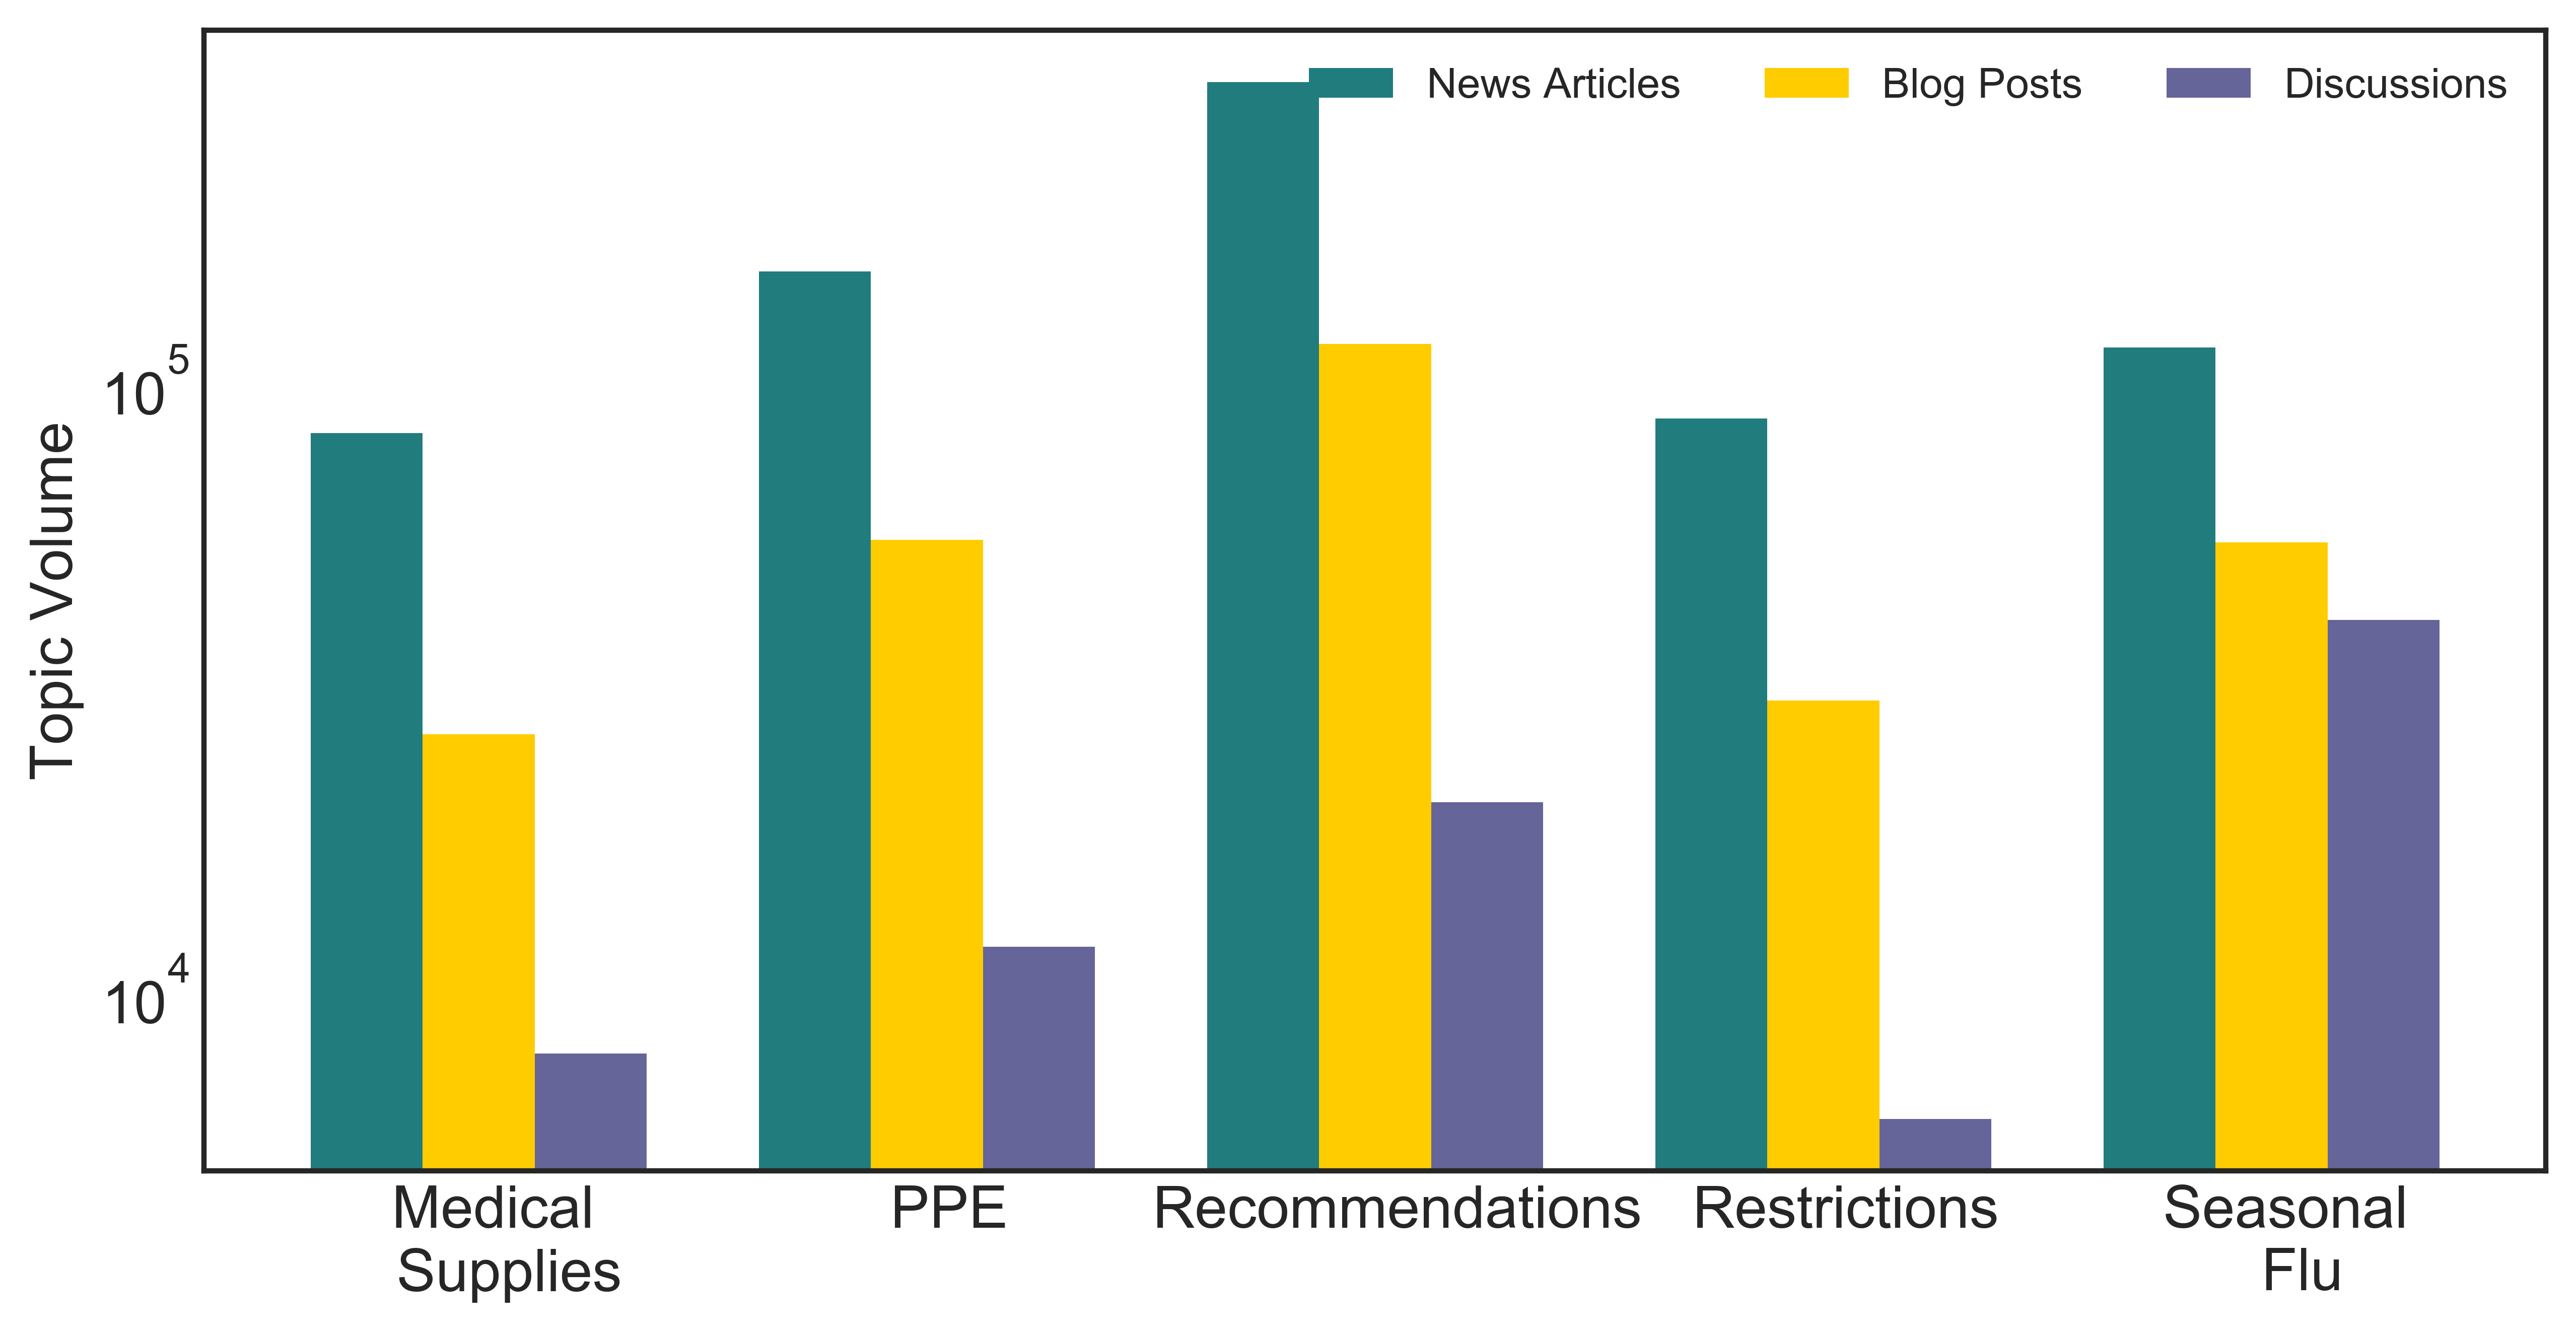

In [21]:
plot_theme_variable("Volume", yscale='log')

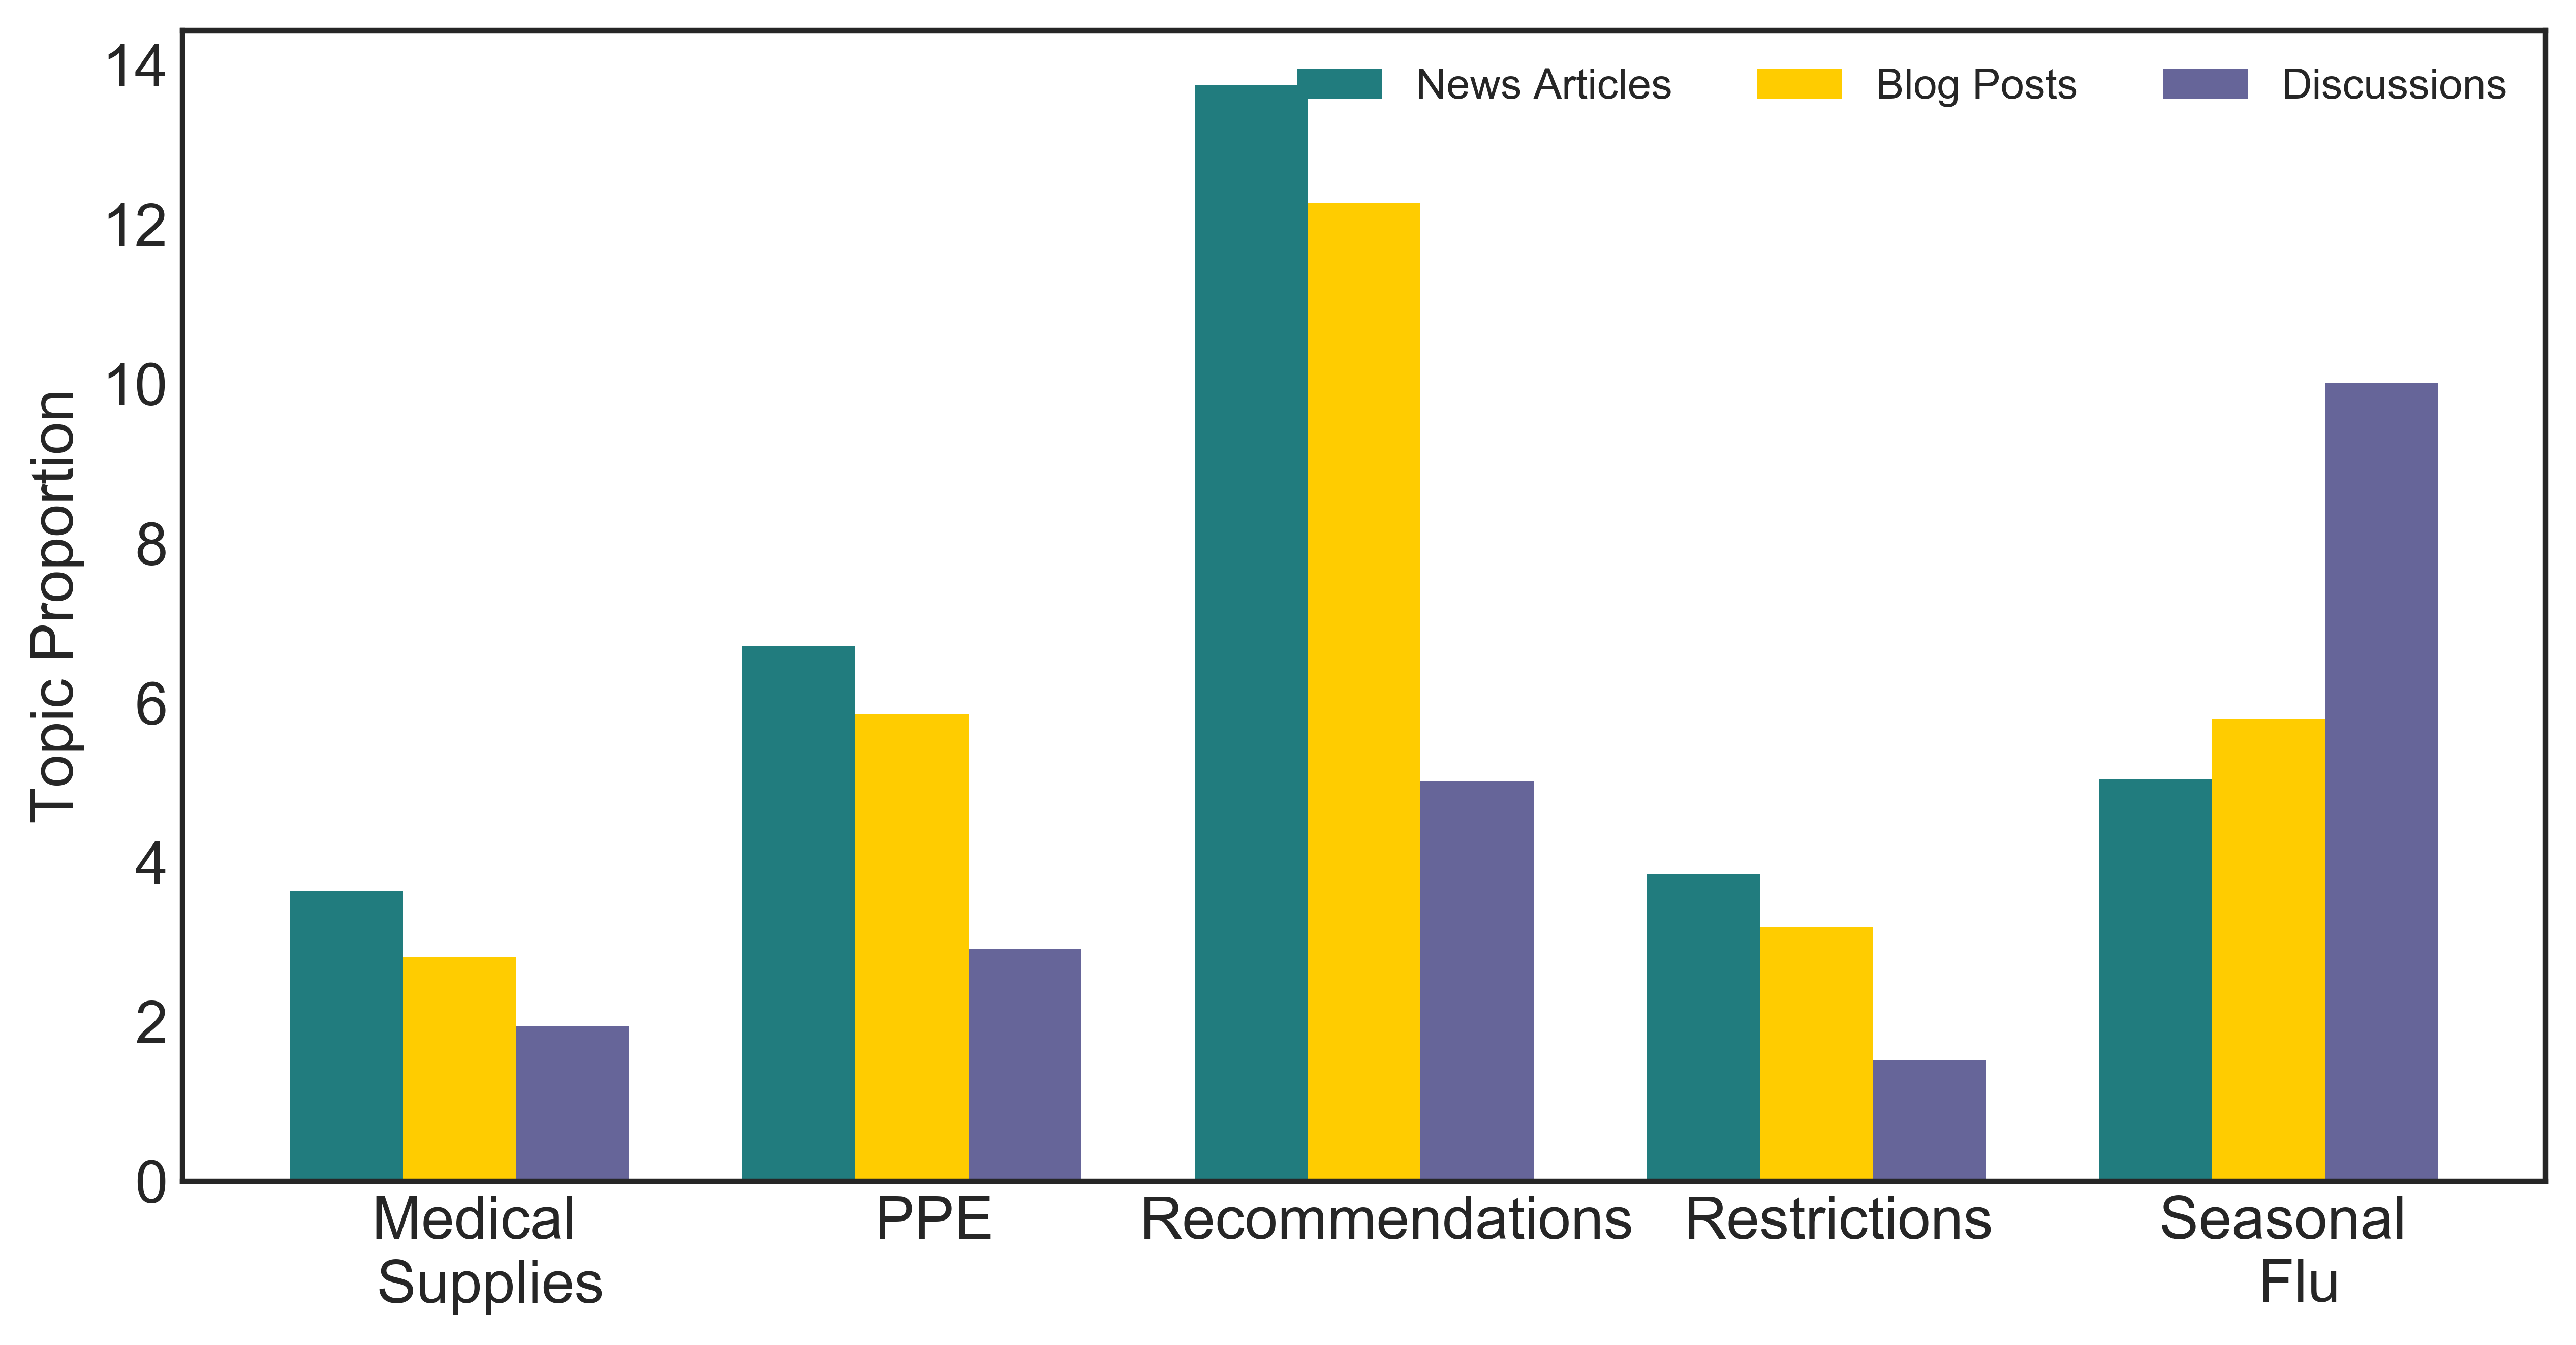

In [22]:
plot_theme_variable("Proportion", yscale='linear')

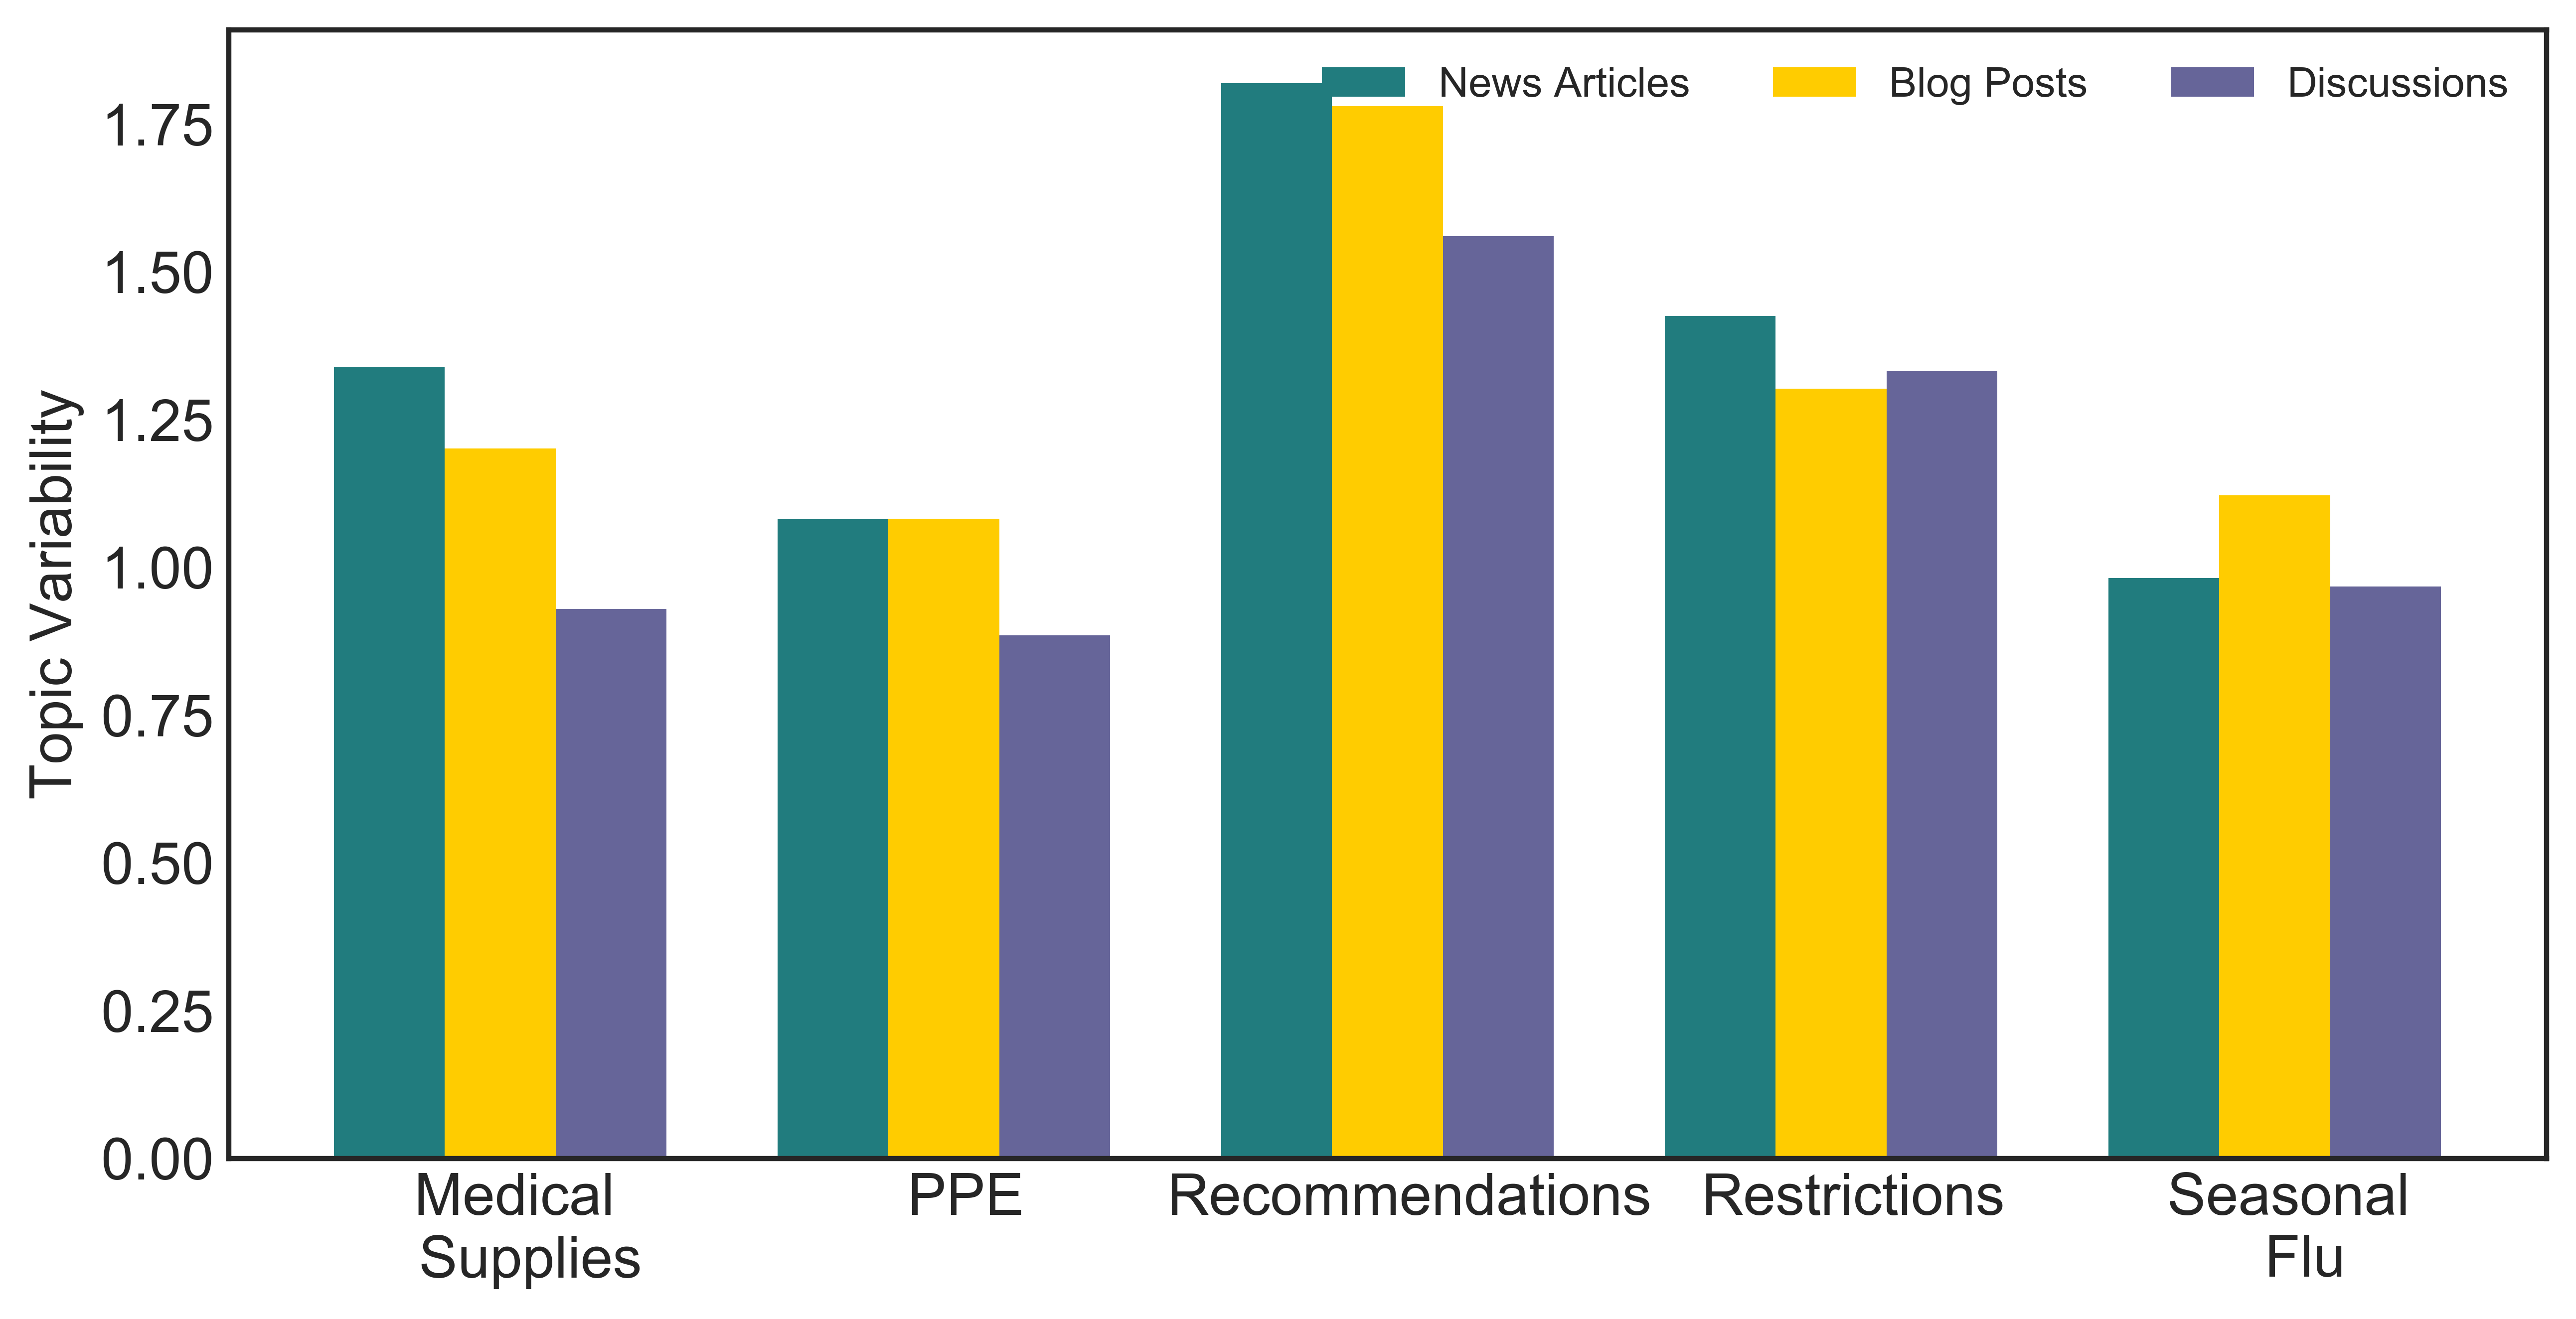

In [23]:
plot_theme_variable("Variability", yscale='linear')

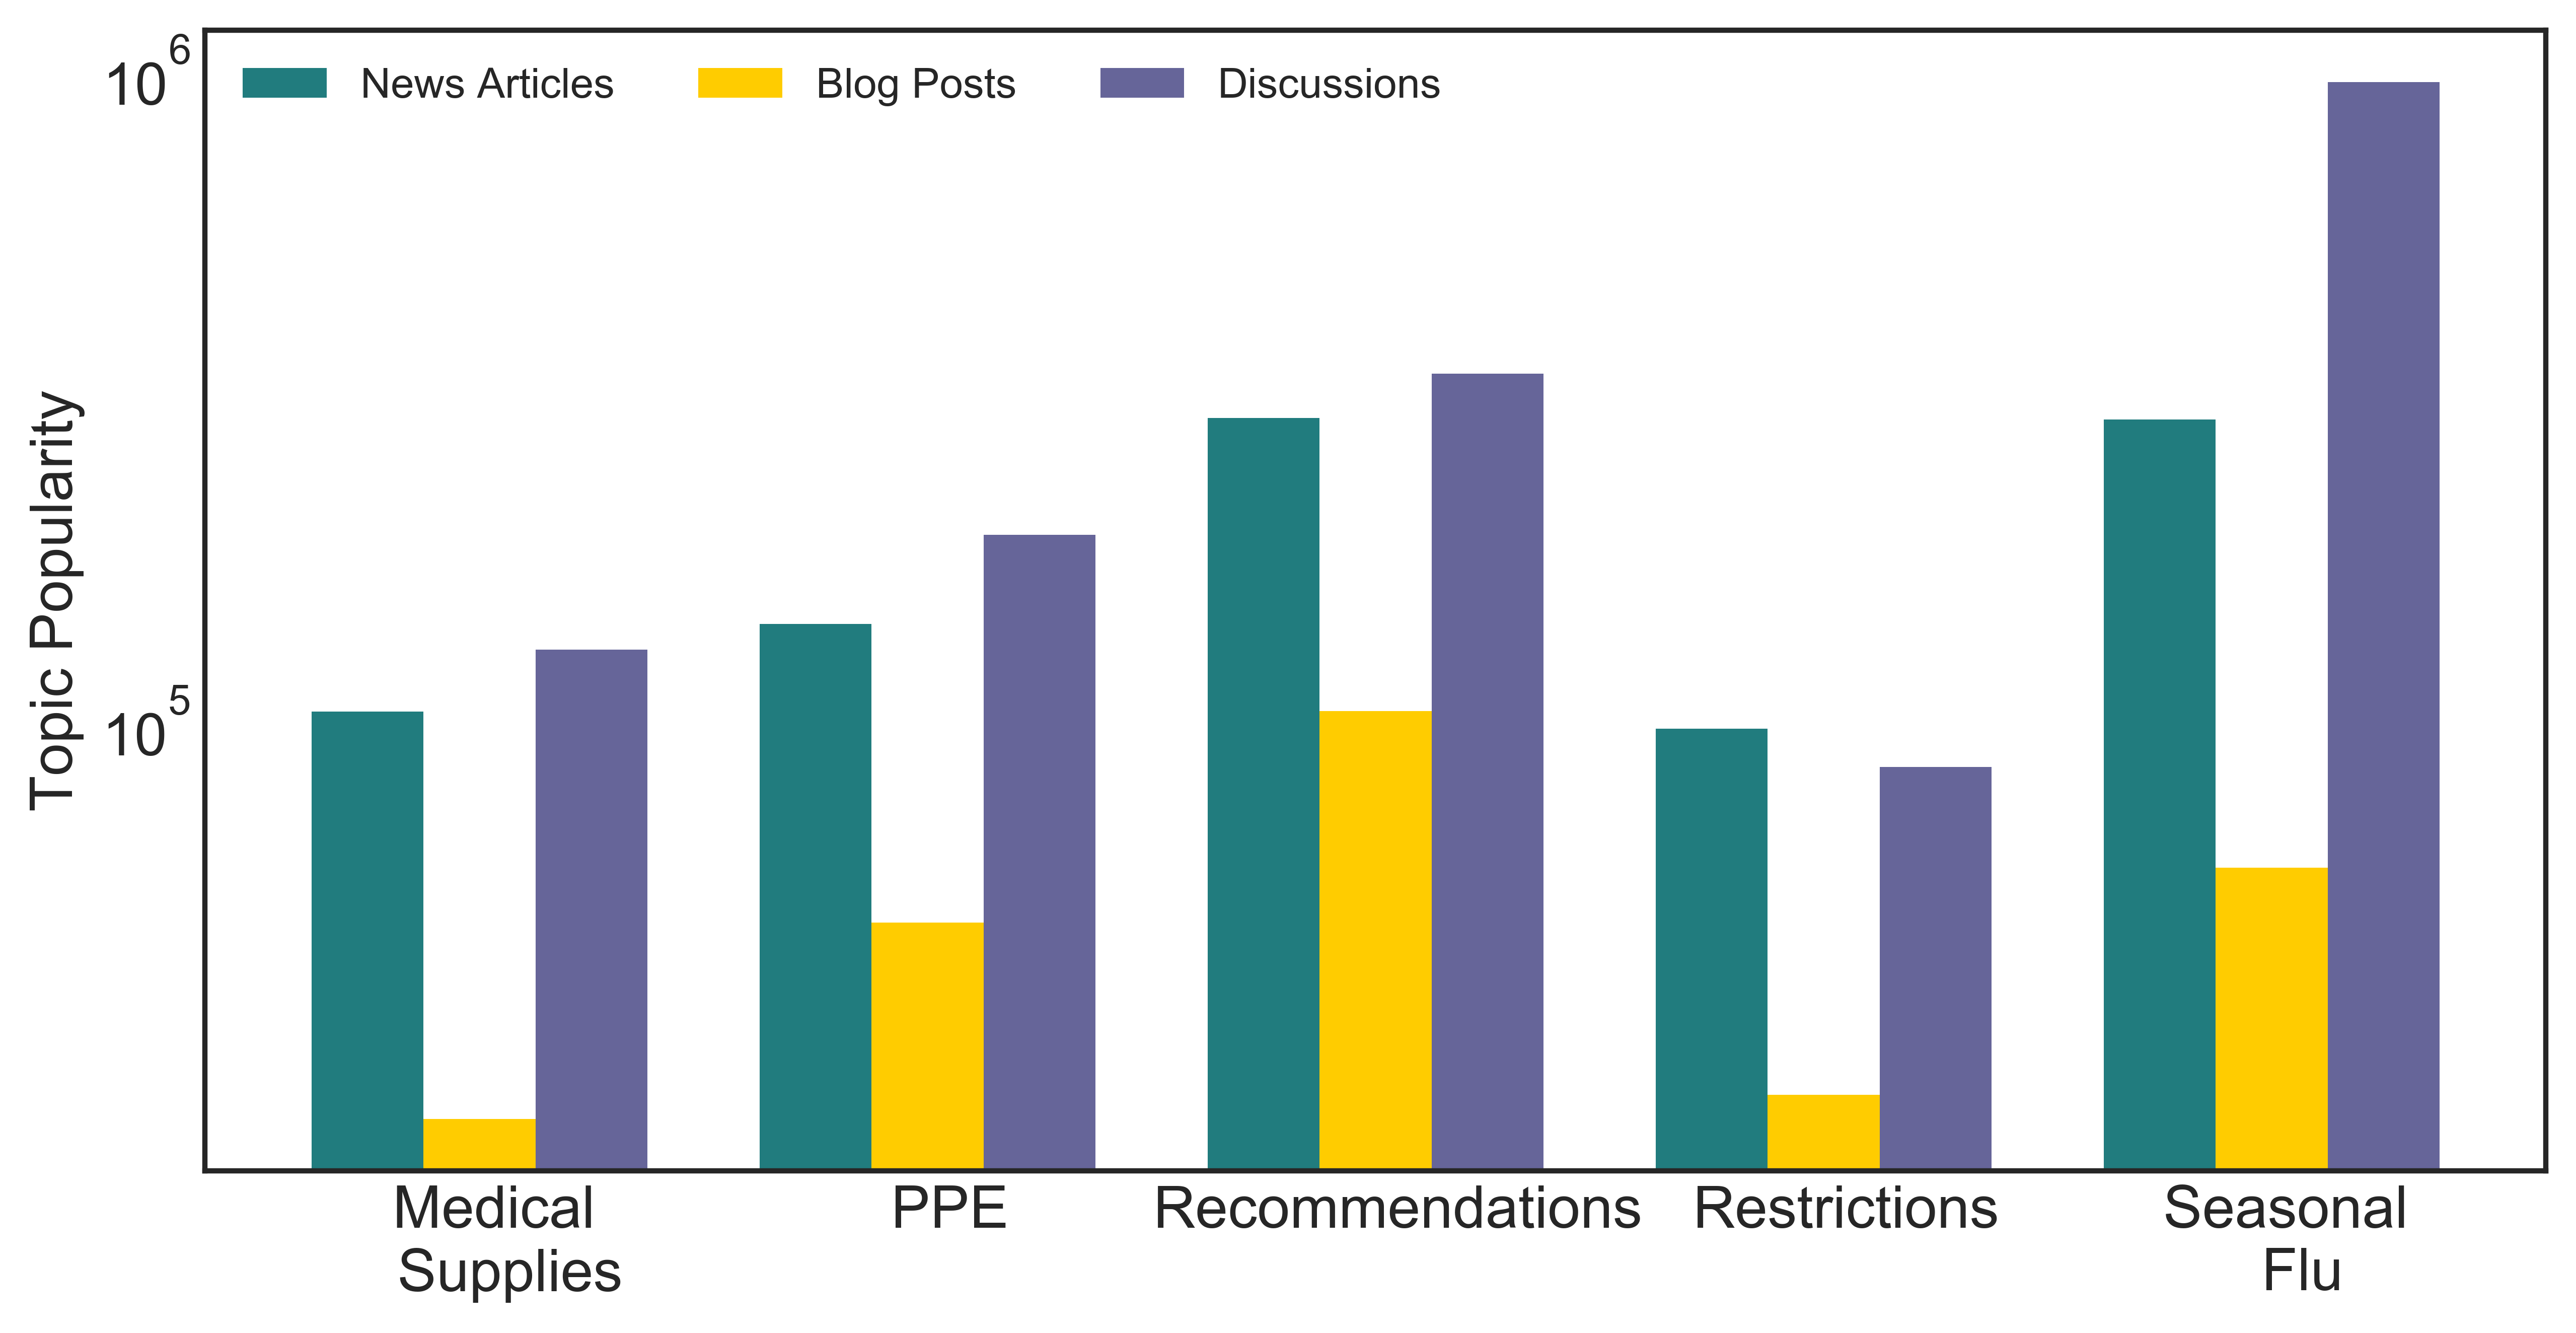

In [24]:
plot_theme_variable("Popularity")

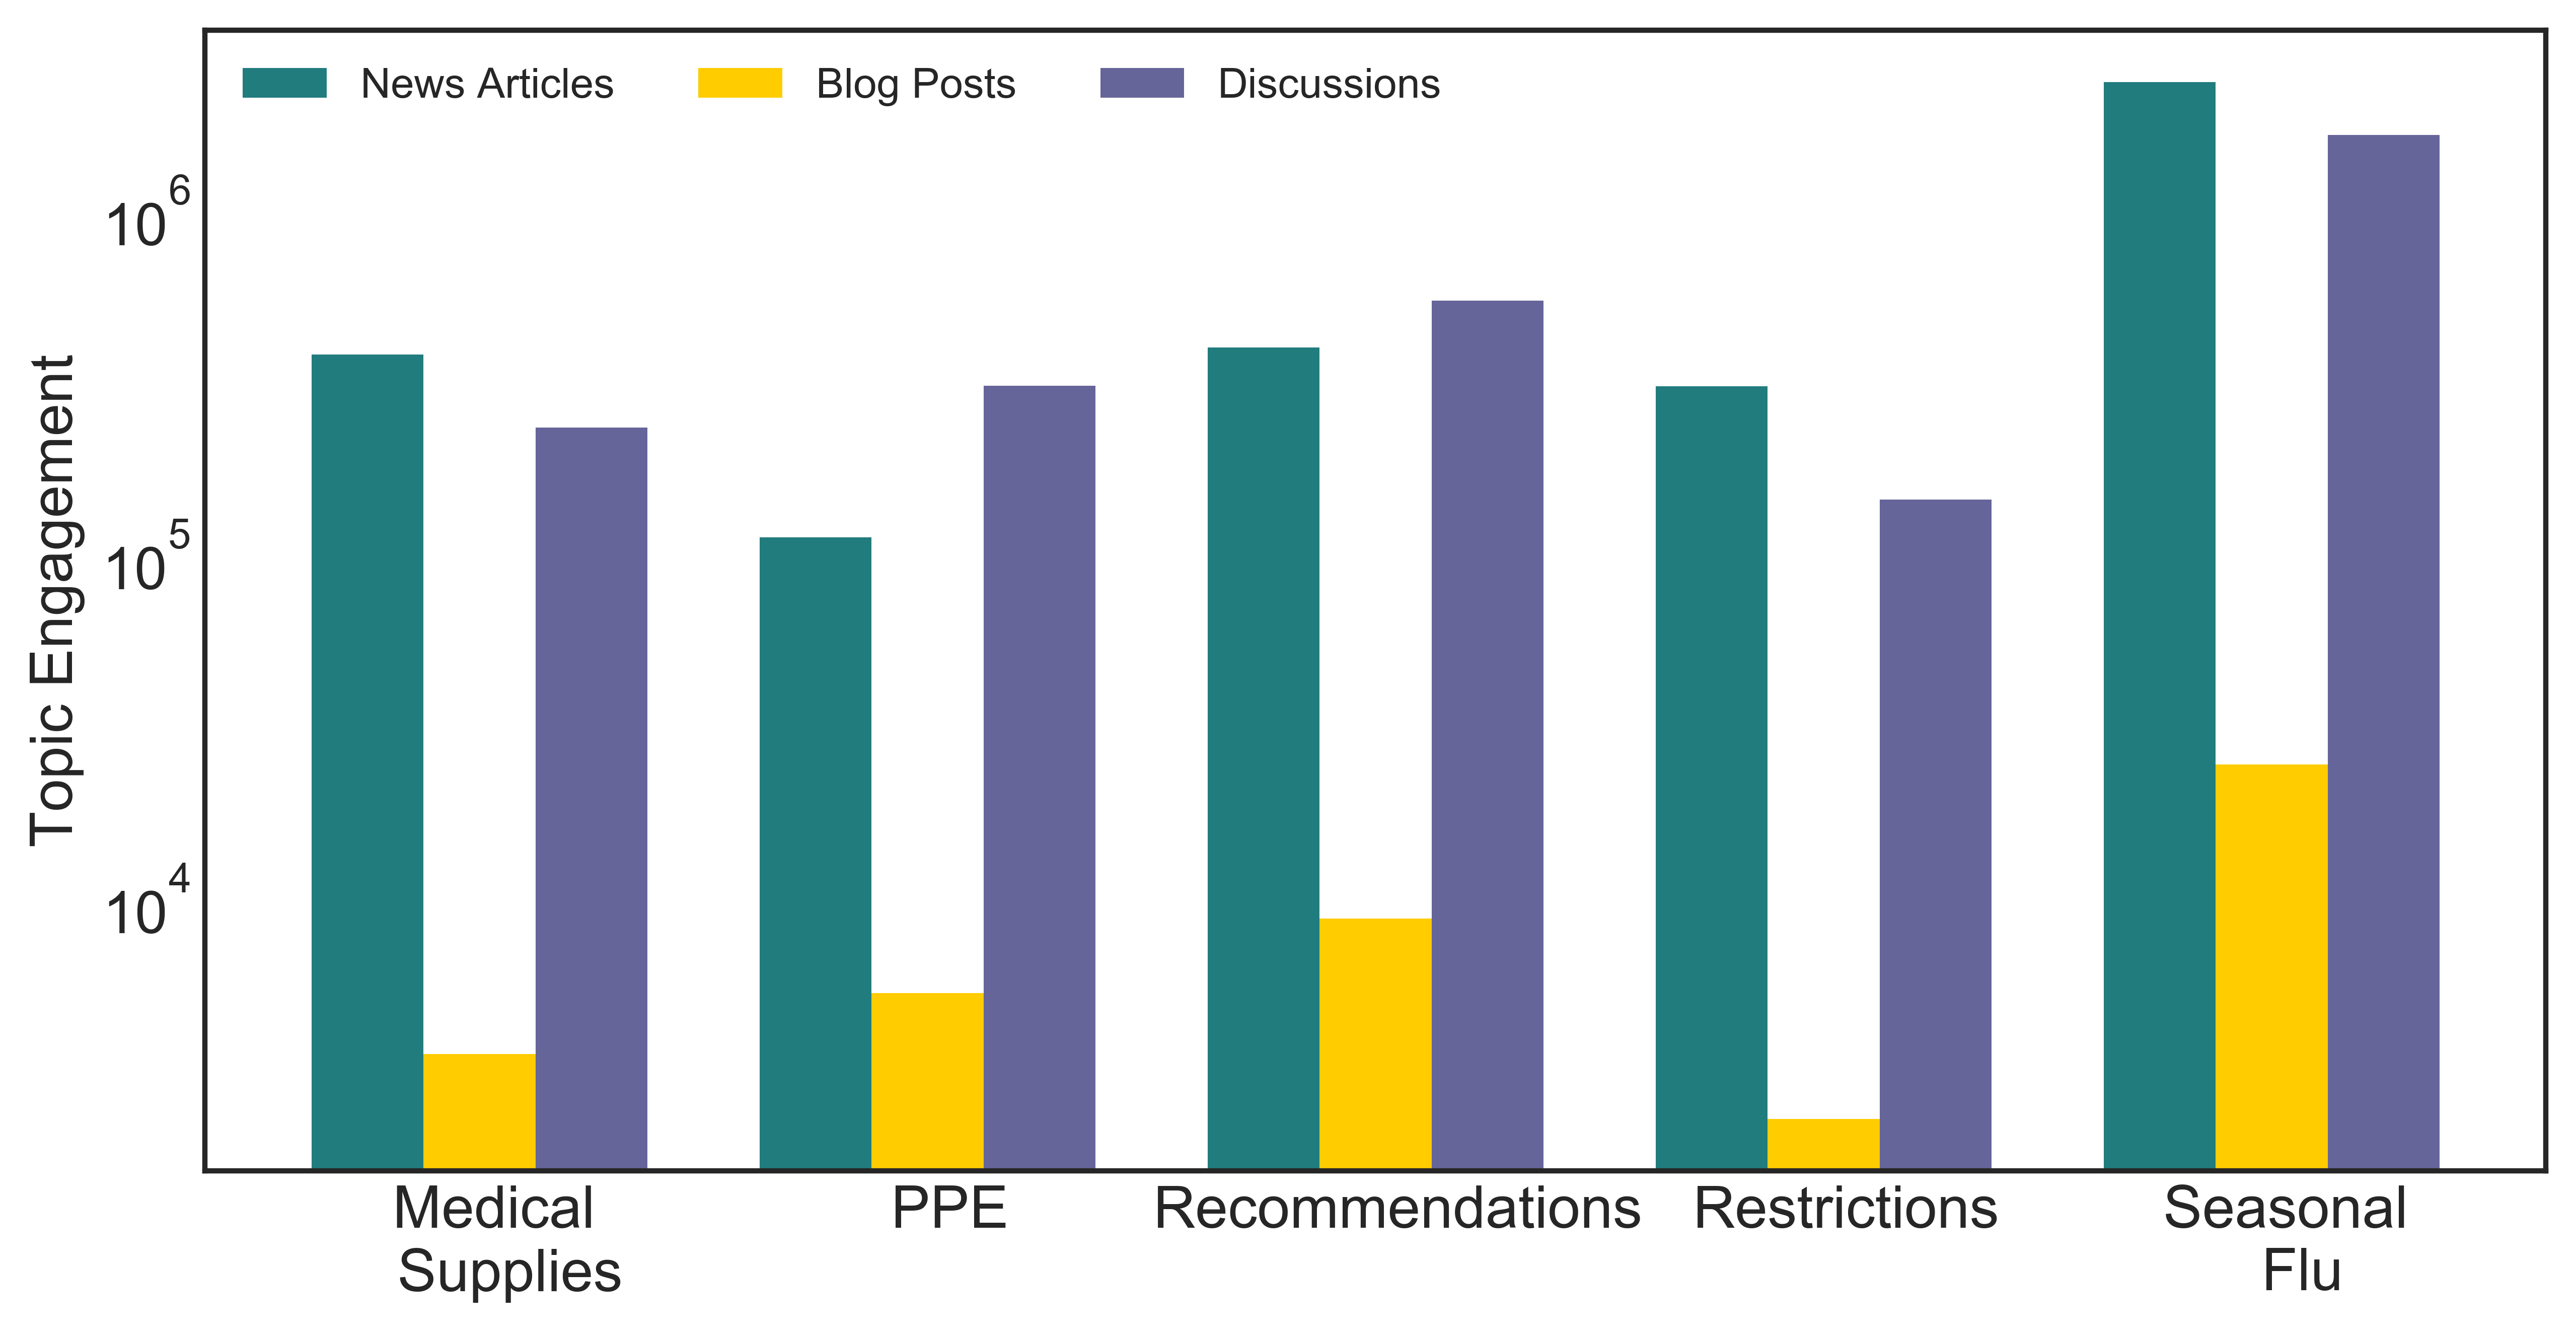

In [25]:
plot_theme_variable("Engagement")

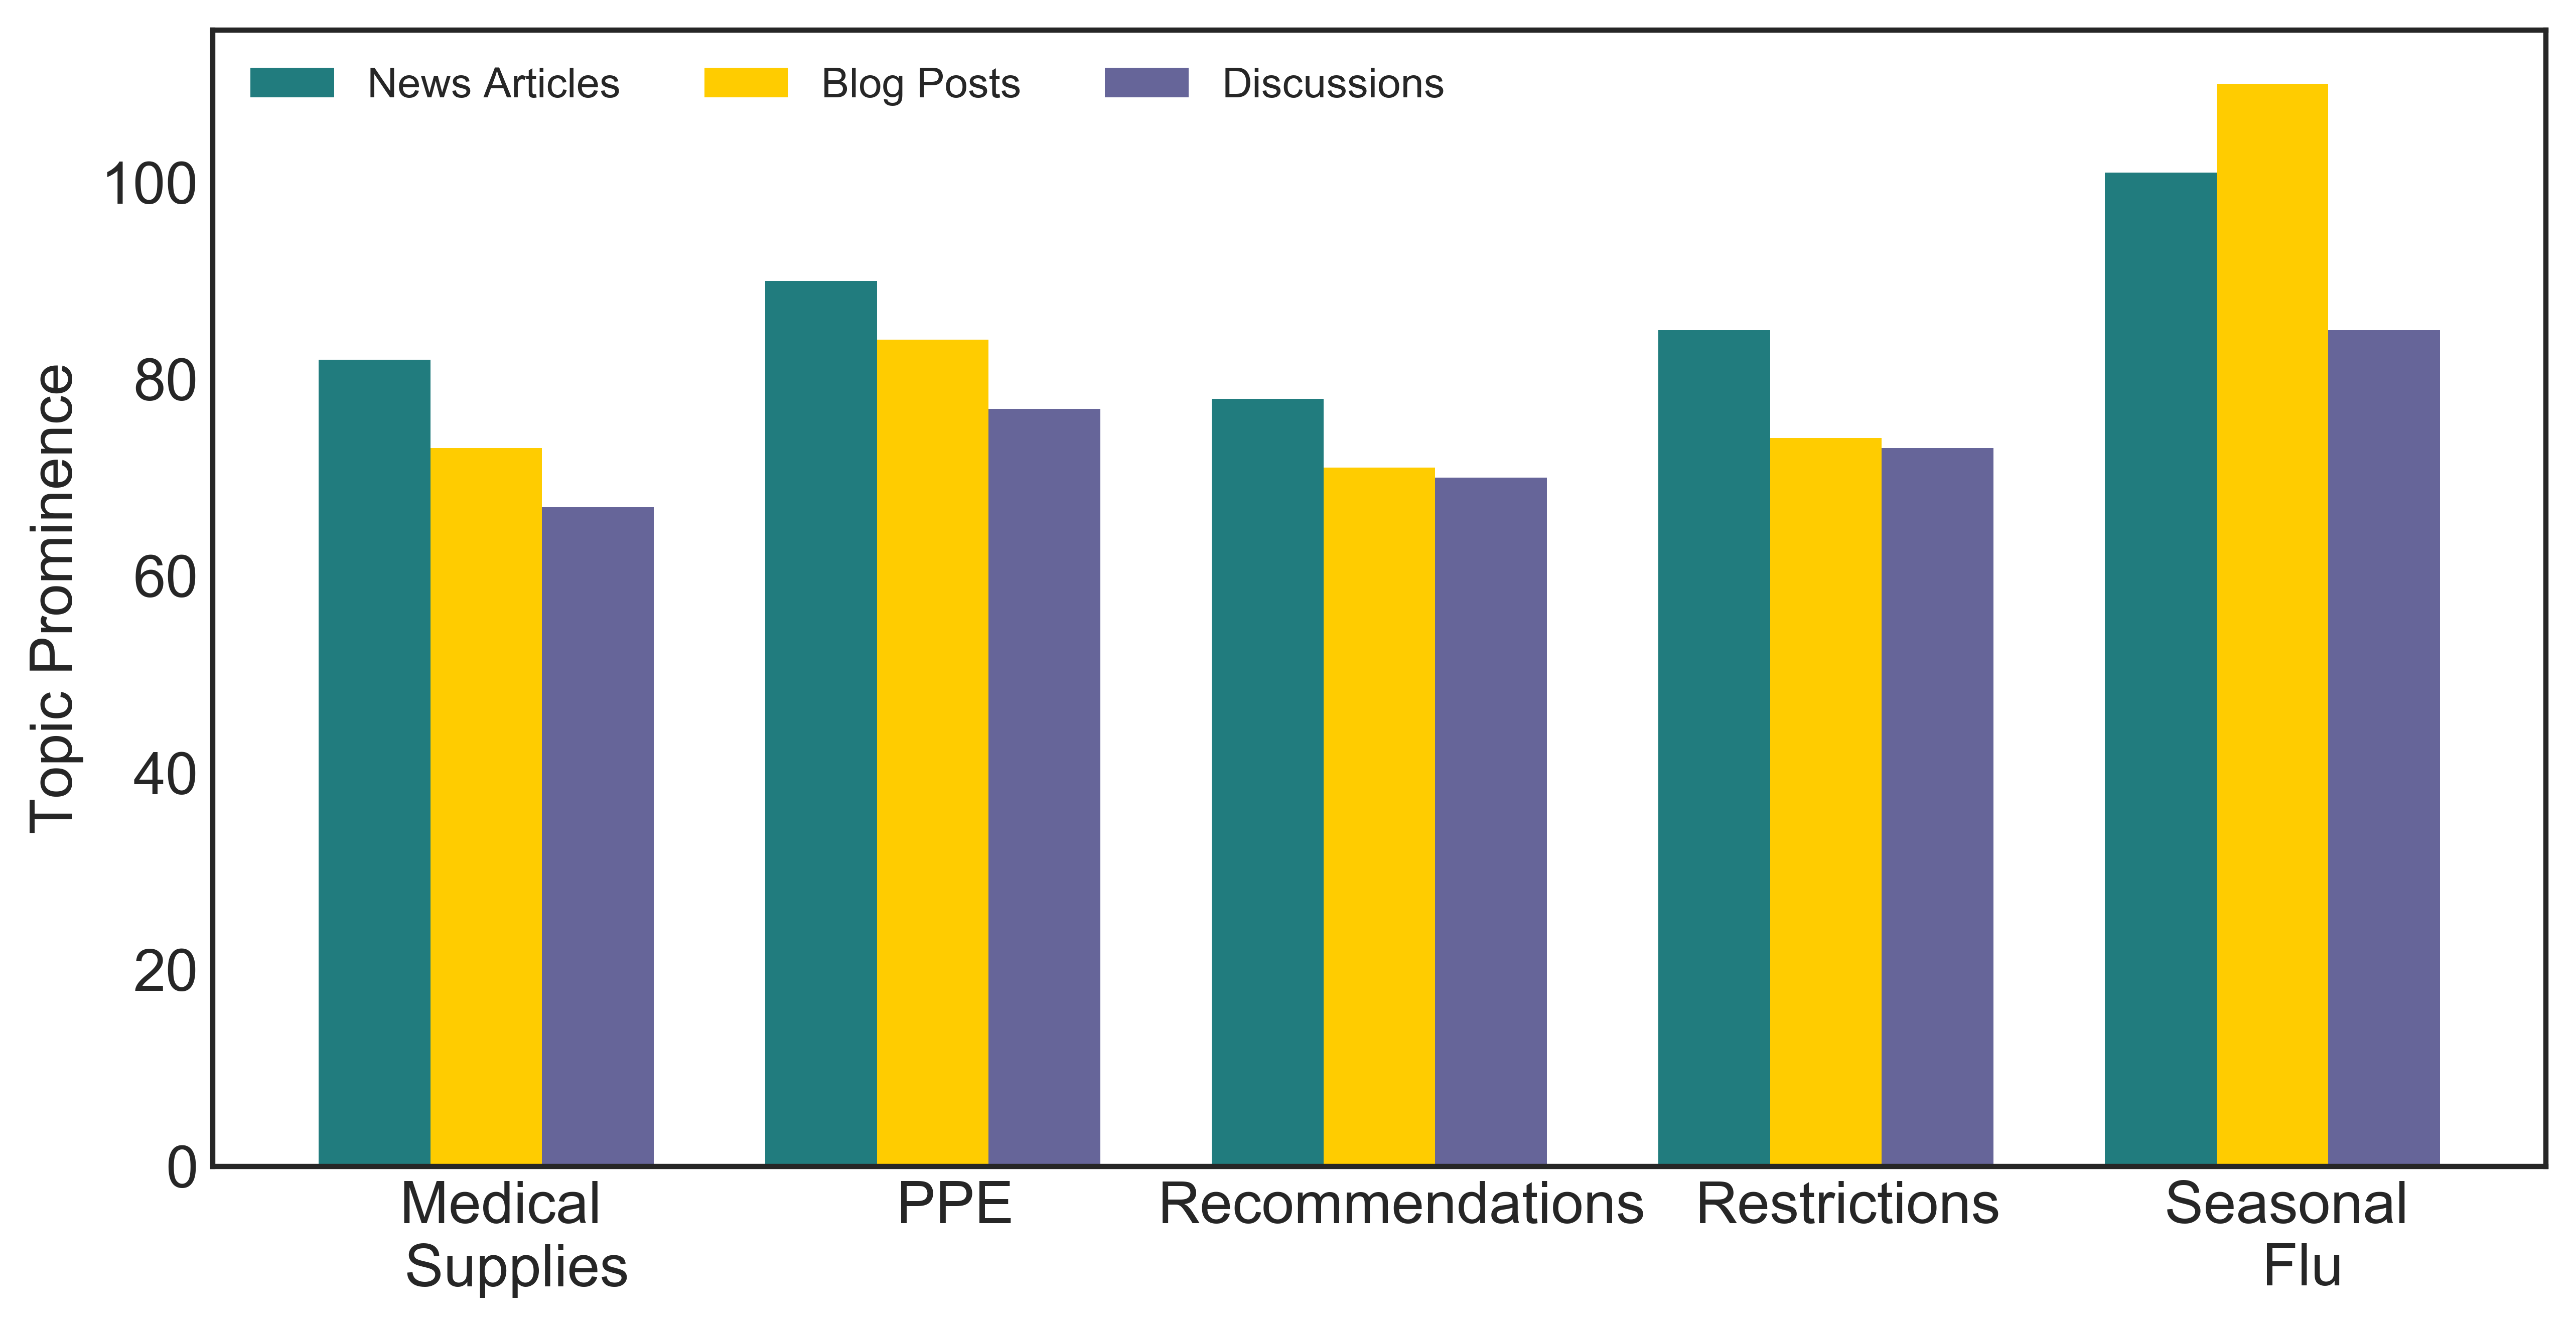

In [26]:
plot_theme_variable("Prominence", yscale='linear')

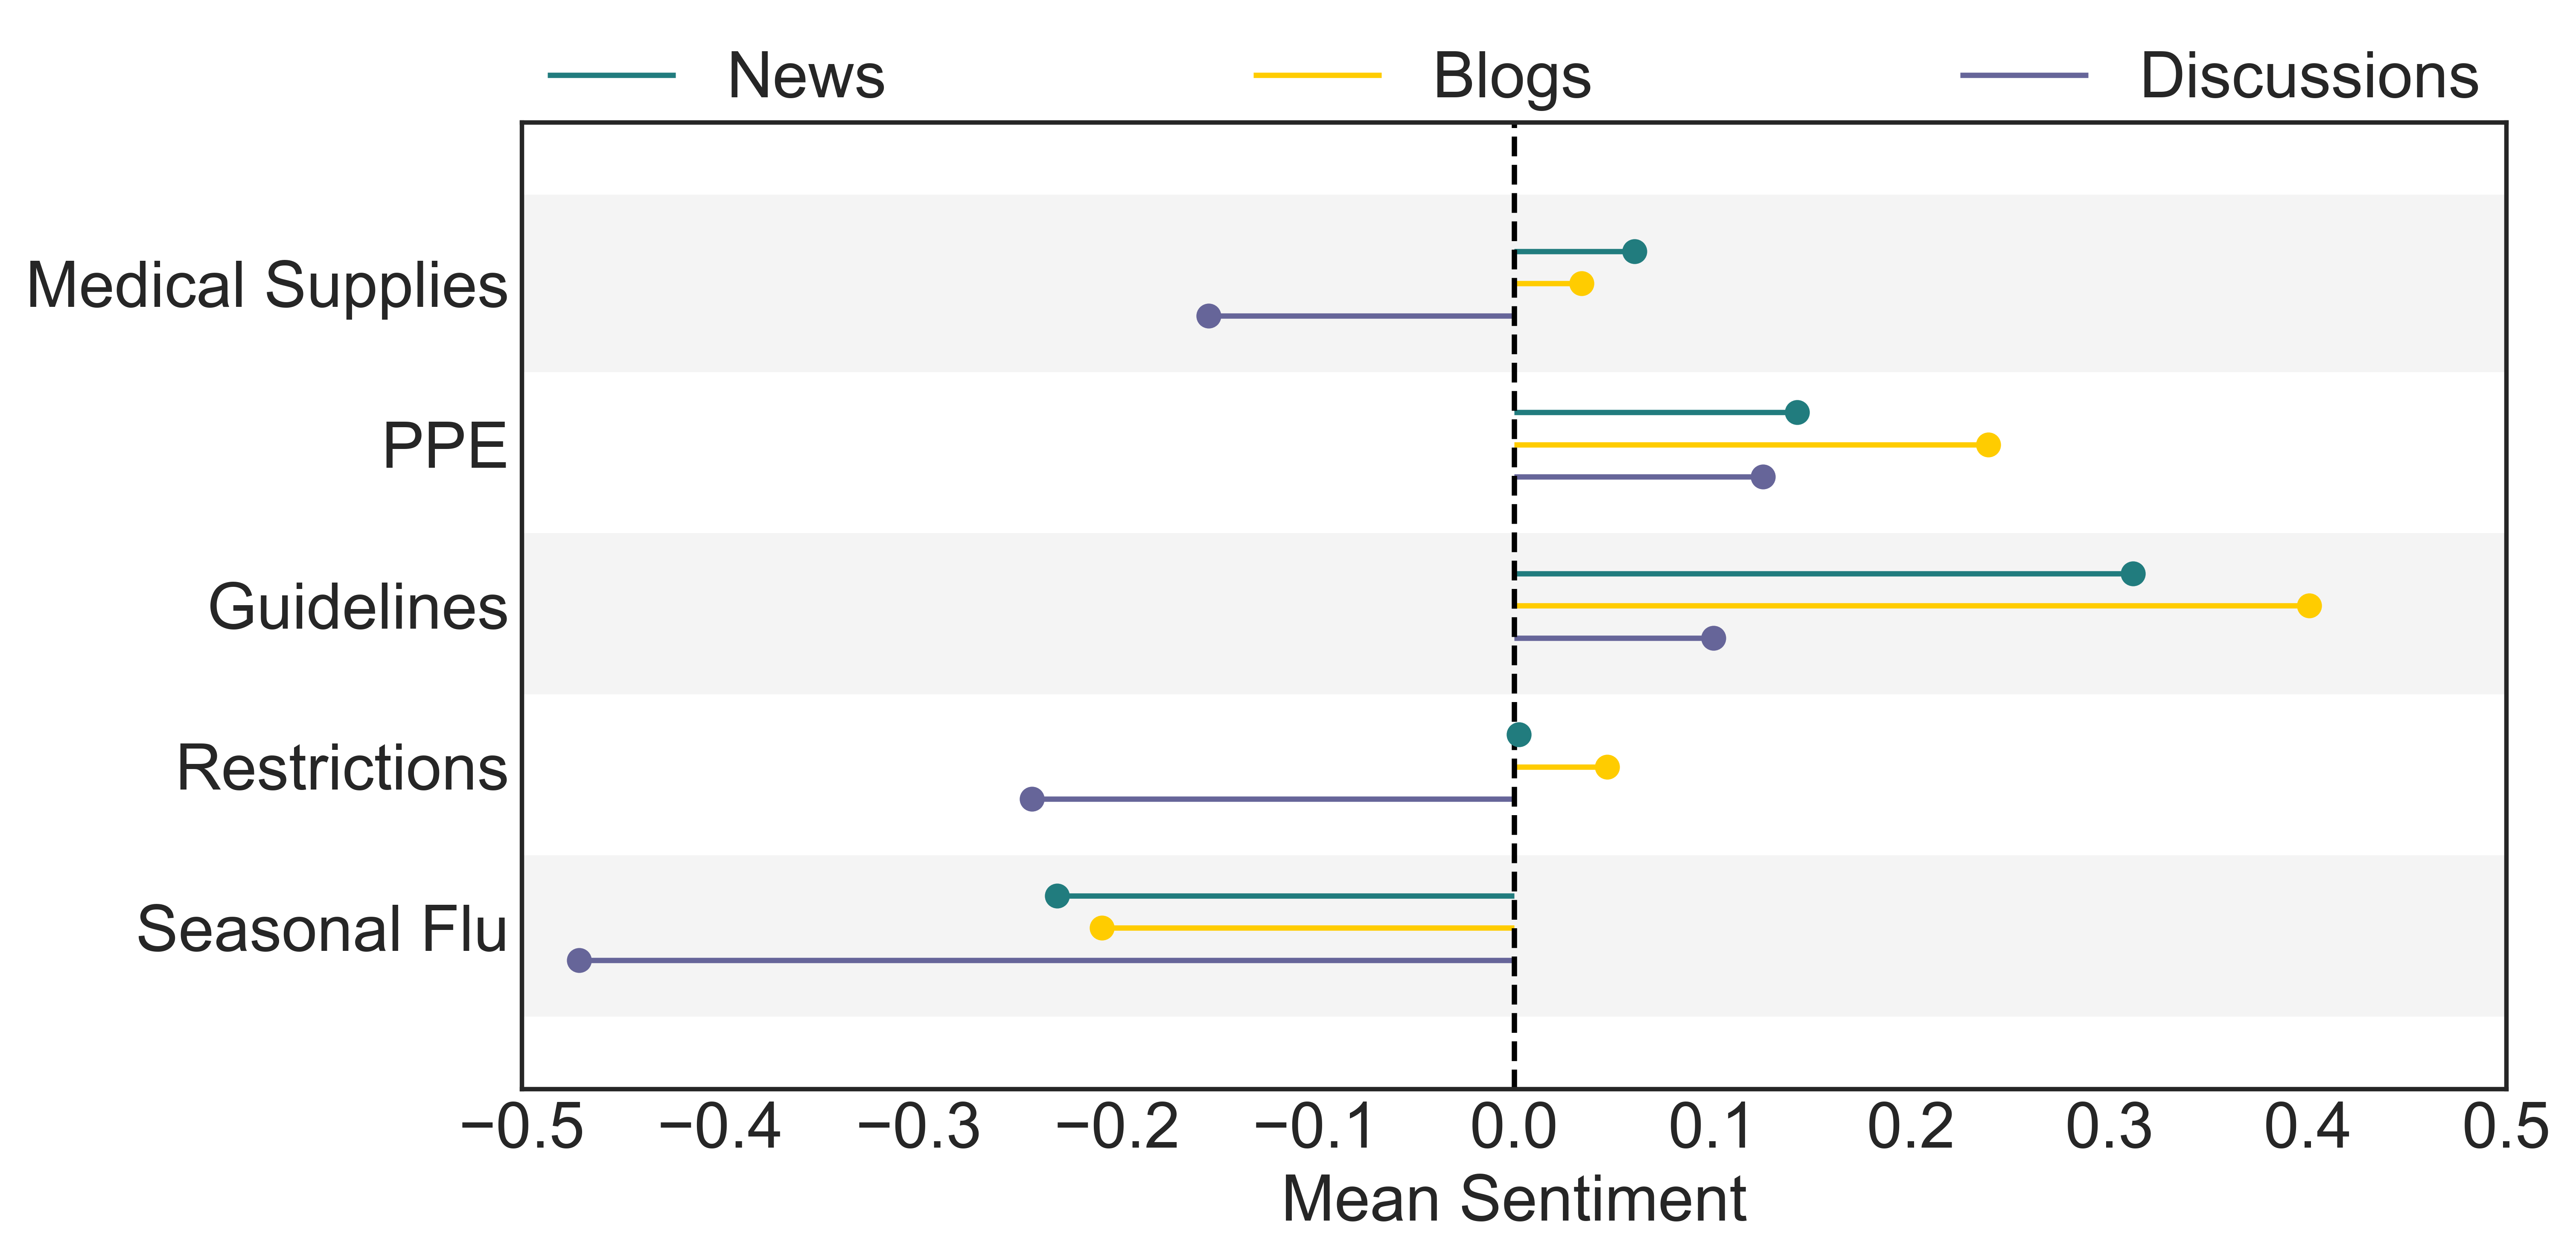

In [27]:
fig = plt.figure(figsize=(10,5), dpi=600)
s=18
news_xvalues = theme_statistics[theme_statistics['Source'].str.contains('News')]['Sentiment']
news_yvalues = [5.2,4.2,3.2,2.2,1.2]
blogs_xvalues = theme_statistics[theme_statistics['Source'].str.contains('Blogs')]['Sentiment']
blogs_yvalues = [5,4,3,2,1]
discussions_xvalues = theme_statistics[theme_statistics['Source'].str.contains('Discussions')]['Sentiment']
discussions_yvalues = [4.8,3.8,2.8,1.8,0.8]


for i, values in enumerate(zip(news_xvalues, blogs_xvalues, discussions_xvalues)):
    plt.errorbar(x=values[0], y=news_yvalues[i], linestyle='-', fmt='o', c=elm)
    plt.hlines(news_yvalues[i], 0, values[0], color=elm)
    plt.errorbar(x=values[1], y=blogs_yvalues[i], fmt='o', c=orange)
    plt.hlines(blogs_yvalues[i], 0, values[1], color=orange)
    plt.errorbar(x=[values[2]], y=discussions_yvalues[i], fmt='o', c=purple)
    plt.hlines(discussions_yvalues[i], 0, values[2], color=purple)

plt.legend(["News", "Blogs", "Discussions"],
           bbox_to_anchor=(0., 1., 1., .1), 
           loc=2, ncol=3, 
           mode="expand", 
           fontsize=s,
           borderaxespad=0)

plt.barh(np.arange(0,6,1), 
        [-2]*6, 
        height=1.1,
        color= ["#FFFFFF","#f4f4f4"]*6,
        edgecolor = "none",
       align="center")
plt.barh(np.arange(0,6,1), 
        [2]*6, 
        height=1.1,
        color= ["#FFFFFF","#f4f4f4"]*6,
        edgecolor = "none",
       align="center")

plt.xticks(np.arange(-.6,.7,.1),fontsize=s)
plt.yticks(np.arange(6), 
           ('', 'Seasonal Flu', 'Restrictions', 'Guidelines', 'PPE', 'Medical Supplies'), 
           fontsize=s)

plt.ylim(0,6)
plt.xlim(-.5,.5)

ax = plt.vlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.xlabel("Mean Sentiment", fontsize=s)

plt.show()

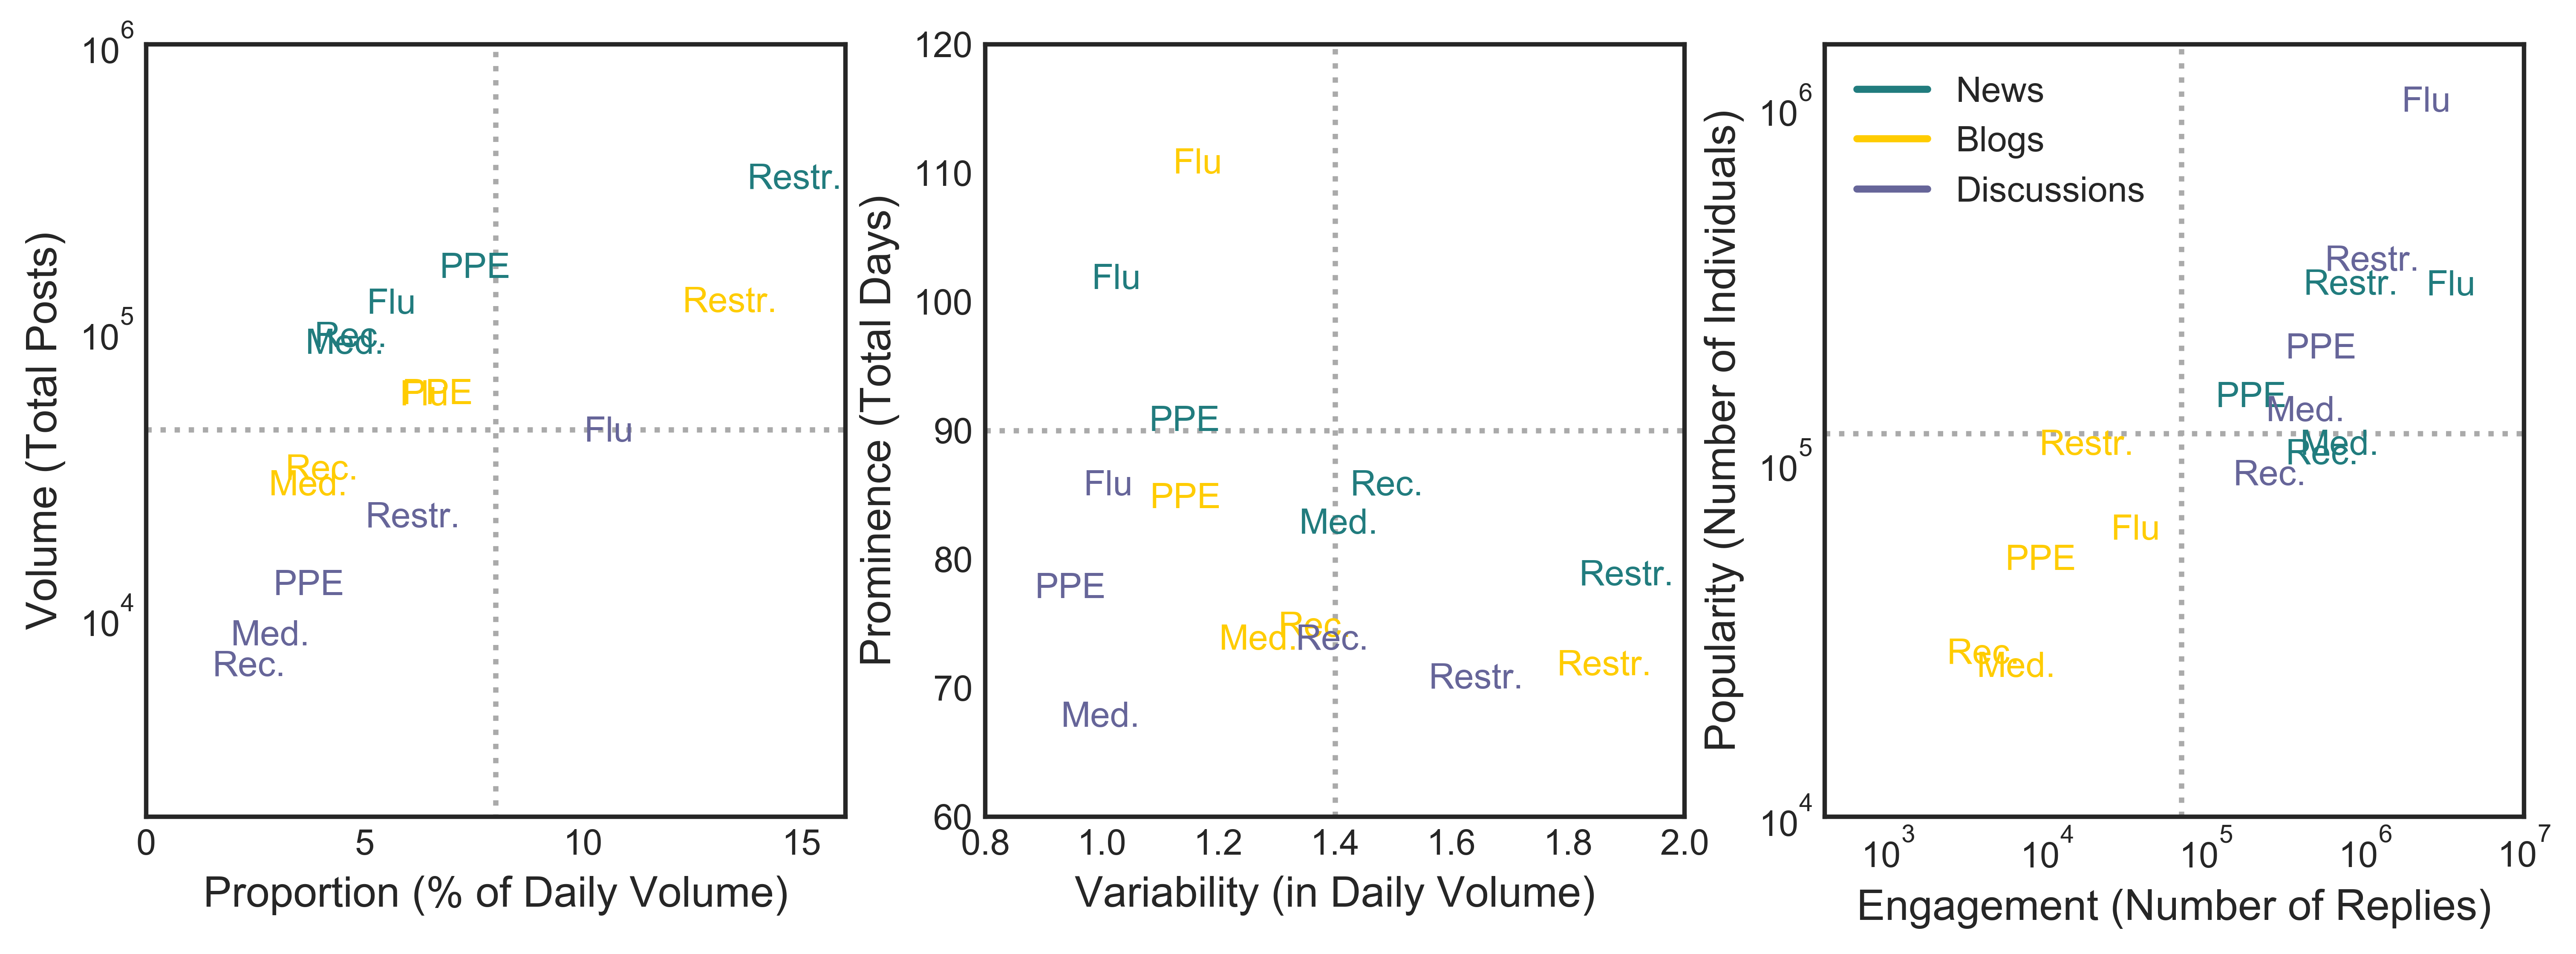

In [28]:
fig = plt.figure(figsize=(12,4), dpi=600)

abbrv = ['Med.', 'PPE', 'Restr.', 'Rec.', 'Flu']
s, ss = 10, 12

news_topics = theme_statistics[theme_statistics['Source']=='News']['Theme'].values
blogs_topics = theme_statistics[theme_statistics['Source']=='Blogs']['Theme'].values
discussions_topics = theme_statistics[theme_statistics['Source']=='Discussions']['Theme'].values

## Left Plot

ax = plt.subplot(1, 3, 1)
ax.scatter(theme_statistics[theme_statistics['Source']=='News']['Proportion'].values,
           theme_statistics[theme_statistics['Source']=='News']['Volume'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='News']['Proportion'].values[i], 
                      theme_statistics[theme_statistics['Source']=='News']['Volume'].values[i]),
                size=s,
                color=elm)
    
ax = plt.subplot(1, 3, 1)
ax.scatter(theme_statistics[theme_statistics['Source']=='Blogs']['Proportion'].values,
           theme_statistics[theme_statistics['Source']=='Blogs']['Volume'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Blogs']['Proportion'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Blogs']['Volume'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 1)
ax.scatter(theme_statistics[theme_statistics['Source']=='Discussions']['Proportion'].values,
           theme_statistics[theme_statistics['Source']=='Discussions']['Volume'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Discussions']['Proportion'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Discussions']['Volume'].values[i]), 
                size=s,
                color=purple)

ax.vlines(8, 500, 1e6, color=grey, linestyles='dotted')
ax.hlines(45000, 0, 16, color=grey, linestyles='dotted')
ax.set_xlim(0,16)
ax.set_ylim(2e3,1e6)
ax.set_yscale('symlog')
ax.set_ylabel('Volume (Total Posts)', fontsize=ss)
ax.set_xlabel('Proportion (% of Daily Volume)', fontsize=ss)

## Middle Plot

ax = plt.subplot(1, 3, 2)
ax.scatter(theme_statistics[theme_statistics['Source']=='News']['Variability'].values,
           theme_statistics[theme_statistics['Source']=='News']['Prominence'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='News']['Variability'].values[i], 
                      theme_statistics[theme_statistics['Source']=='News']['Prominence'].values[i]),
                size=s,
                color=elm)
    
ax = plt.subplot(1, 3, 2)
ax.scatter(theme_statistics[theme_statistics['Source']=='Blogs']['Variability'].values,
           theme_statistics[theme_statistics['Source']=='Blogs']['Prominence'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Blogs']['Variability'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Blogs']['Prominence'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 2)
ax.scatter(theme_statistics[theme_statistics['Source']=='Discussions']['Variability'].values,
           theme_statistics[theme_statistics['Source']=='Discussions']['Prominence'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Discussions']['Variability'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Discussions']['Prominence'].values[i]), 
                size=s,
                color=purple)

ax.vlines(1.4, 60,120, color=grey, linestyles='dotted')
ax.hlines(90, .8,2, color=grey, linestyles='dotted')
ax.set_xlim(.8,2)
ax.set_ylim(60,120)
ax.set_ylabel('Prominence (Total Days)', fontsize=ss)
ax.set_xlabel('Variability (in Daily Volume)', fontsize=ss)


## Right Plot

ax = plt.subplot(1, 3, 3)
ax.scatter(theme_statistics[theme_statistics['Source']=='News']['Engagement'].values,
           theme_statistics[theme_statistics['Source']=='News']['Popularity'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='News']['Engagement'].values[i], 
                      theme_statistics[theme_statistics['Source']=='News']['Popularity'].values[i]),
                size=s,
                color=elm)

    
ax = plt.subplot(1, 3, 3)
ax.scatter(theme_statistics[theme_statistics['Source']=='Blogs']['Engagement'].values,
           theme_statistics[theme_statistics['Source']=='Blogs']['Popularity'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Blogs']['Engagement'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Blogs']['Popularity'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 3)
ax.scatter(theme_statistics[theme_statistics['Source']=='Discussions']['Engagement'].values,
           theme_statistics[theme_statistics['Source']=='Discussions']['Popularity'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(abbrv[i], (theme_statistics[theme_statistics['Source']=='Discussions']['Engagement'].values[i], 
                      theme_statistics[theme_statistics['Source']=='Discussions']['Popularity'].values[i]), 
                size=s,
                color=purple)    

ax.vlines(70000, 1e4, 1e7, color=grey, linestyles='dotted')
ax.hlines(120000, 400, 1e7, color=grey, linestyles='dotted')
ax.set_xlim(400,1e7)
ax.set_ylim(1e4,1500000)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_xlabel('Engagement (Number of Replies)', fontsize=ss)
ax.set_ylabel('Popularity (Number of Individuals)', fontsize=ss)

custom_lines = [Line2D([0], [0], color=elm, lw=2),
                Line2D([0], [0], color=orange, lw=2),
                Line2D([0], [0], color=purple, lw=2)]

plt.legend(custom_lines, ['News', 'Blogs', 'Discussions'])

plt.show()